# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [4]:
#!pip -q install ./python

In [3]:
path20 = r"C:\Users\adith\Desktop\Meng Robotics\reinforcement\Banana\Cont-Control\Unity-ml-env-arm\20agents\Reacher_Windows_x86_64\Reacher"
pathTen = r"C:\Users\adith\Desktop\Meng Robotics\reinforcement\Banana\MADDPG\Multiagent\Tennis_Windows_x86_64\Tennis"
path1 = r"C:\Users\adith\Desktop\Meng Robotics\reinforcement\Banana\Cont-Control\Unity-ml-env-arm\Reacher_Windows_x86_64\Reacher"

In [4]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [5]:


# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
env = UnityEnvironment(file_name=pathTen , seed=1)
# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain_name

'TennisBrain'

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
print("states 1 ", states[1,:])
state_size = states.shape[1]
Critic_state = np.reshape(states , (48))
agent_1_state = np.array(Critic_state)[0:int(state_size)]
print("state given", states, "Critic_state", Critic_state , agent_1_state)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
states 1  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.07908773 -1.5
  0.          0.         -6.00063038  6.          0.          0.        ]
state given [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.63803244 -1.5
  -0.          0.          6.00063038  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -7.07908773 -1.5
   0.          0.         -6.00063038  6.          0.          0.        ]] Critic_state [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09500000160187483


In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        #print(e)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim



#Memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device that will be used is ", device)
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size,random_seed, num_agents = 1 ,agent_id = None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.Comstate_size = state_size * num_agents
        self.Comaction_size = action_size *num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.updateCounter = UpdateCount
        
        if(num_agents > 1 and agent_id == None):
            print("error agent id has to be there")
        else: 
            if(agent_id != None and num_agents >1):
                self.agent_id = agent_id
            

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(self.state_size, action_size, random_seed).to(device)
        print("actor model been used .. for agent number",self.agent_id, self.actor_local)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        print("actor optim", self.actor_optimizer)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.Comstate_size, self.Comaction_size, random_seed).to(device)
        self.critic_target = Critic(self.Comstate_size, self.Comaction_size, random_seed).to(device)
        print("critic model which is used for agent number",self.agent_id, self.critic_local)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        print("critic optim", self.critic_optimizer)

        # Noise process
        self.noise = OUNoise((1, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def AllAgentsRef(self, all_agents):
        if(num_agents > 1):
            self.All_agents = all_agents
        else:
            print("for just one agent is not required")
    
    def step(self, state, action, reward, next_state, done , agent_id = None):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        
        if (self.num_agents > 1 and agent_id == None):
            print("agent id can be none")
            
        if(self.agent_id != agent_id):
            print("agent has to be the same")
        
        
#         for s,a,r,n_s,d in zip(state,action,reward,next_state,done):
#             self.memory.add(s, a, r, n_s, d)
        self.memory.add(state ,action , reward , next_state , done)
            
        self.updateCounter -=1
        #print(self.updateCounter)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.updateCounter <= 0:
            #print("updating")
            self.updateCounter = UpdateCount
            for _ in range(UpdateNo):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA , agent_id)

    def act(self, state, add_noise=True , noise = 1):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
           #print("actions size here" , actions)
        if add_noise:
            #print("noise check", self.noise.sample())
            #print(noise * self.noise.sample())
            action += noise * self.noise.sample()
        self.actor_local.train()
        return np.clip(action, -1, 1)
    
    def act2(self, states, add_noise , noise = 0):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((1, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                #print(state , agent_num)
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        #print("noise",eps,self.noise.sample())
        if add_noise:
            #print("before noise",actions)
            actions += noise * self.noise.sample()
            #print("after noise",actions)
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

        
    
    def learn(self, experiences, gamma , agent_id = None):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
#             # ---------------------------- update critic ---------------------------- #
#         # Get predicted next-state actions and Q values from target models
#         states, actions, rewards, next_states, dones = experiences
#         #print("input actions", actions)
#         actions_next = self.actor_target(next_states)
                    
#         if agent_id == 0:
#             #print("actions for agent id ", agent_id , "actions target", actions_next , actions[:,2:])
#             actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
#         else:
#             #print("actions for agent id ", agent_id , "actions target", actions_next , actions[:,:2])
#             actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
#         # Predicted Q value from Critic target network
#         Q_targets_next = self.critic_target(next_states, actions_next)
#         # Actual Q value based on reward received at next step plus future expected rewards from Critic target network
#         Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
#         # Compute critic loss
#         Q_expected = self.critic_local(states, actions)

#         # Update priority in PER
#         #loss  = (Q_expected - Q_targets).pow(2).reshape(is_weight.shape) * is_weight
#         #self.memory.update(idxs, loss.data.cpu().numpy())

#         # Minimize critic loss
#         critic_loss = F.mse_loss(Q_expected, Q_targets)
#         self.critic_optimizer.zero_grad()
#         critic_loss.backward()
#         self.critic_optimizer.step()

#         # ---------------------------- update actor ---------------------------- #
#         # Compute actor loss
#         actions_pred = self.actor_local(states)
        
#         if agent_id == 0:
#             #print("actions for agent id ", agent_id , "actions", actions_pred , actions[:,2:])
#             actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
#         else:
#             #print("actions for agent id ", agent_id , "actions", actions_pred , actions[:,:2])
#             actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        
#         #print("final actions ", actions_pred)
#         actor_loss = -self.critic_local(states, actions_pred).mean()
#         # Minimize the loss
#         self.actor_optimizer.zero_grad()
#         actor_loss.backward()
#         self.actor_optimizer.step()

#         # ----------------------- update target networks ----------------------- #
#         self.soft_update(self.critic_local, self.critic_target, TAU)
#         self.soft_update(self.actor_local, self.actor_target, TAU)  
        
        
        
        
        
        states, actions, rewards, next_states, dones = experiences
        #print("learning for the agent id", agent_id)
        if (self.num_agents > 1):
            #this is for multiagent case
            # agent actor input which uses only local obs next_states[:,i*(self.state_size):(i*self.state_size)+self.state_size
            
            # for action next if i == agent_id else actions[:, i*(self.action_size):(i*self.action_size)+self.action_size].detach() 
            if(agent_id == None): 
                print("Error beep beep beep....")
            actions_next = [self.All_agents[i].actor_target(next_states[:,i*(self.state_size):(i*self.state_size)+self.state_size]).detach() for i in range(self.num_agents)]
            actions_next = torch.stack(actions_next)
            actions_next = torch.cat((actions_next[0,:,:], actions_next[1,:,:]), dim=1)
            #print("actions next" , actions_next  , "reshape" ,  actions_next_re)
        else:
            #this is for single agent case
            actions_next = self.actor_target(next_states)
        

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        #actions_next = self.actor_target(next_states)
        #print("next_state",next_states.size())
        #print("act next",actions_next.size())
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones)).detach()
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        #critic_loss = F.smooth_l1_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
    
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        if(num_agents > 1):
            #check = ["oo" if i == agent_id else "yes" for i in range(num_agents)]
            #print(check)
            # idx for local obs :,i*(self.state_size):(i*self.state_size)+self.state_size
            actions_pred = [self.All_agents[i].actor_local(states[:,i*(self.state_size):(i*self.state_size)+self.state_size]) if (i == agent_id) else actions[:, i*(self.action_size):(i*self.action_size)+self.action_size].detach() for i in range(self.num_agents)]
            actions_pred = torch.stack(actions_pred)
            #print(actions_pred)
            actions_pred = torch.cat((actions_pred[0,:,:], actions_pred[1,:,:]), dim=1)
            #print(actions_pred)
        else:
            actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        #print("hello")
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state



the device that will be used is  cuda:0


In [11]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128      # minibatch size

GAMMA = 0.99            # discount factor
TAU = 6e-2             # for soft update of target parameters

LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic

WEIGHT_DECAY = 0.000   # L2 weight decay

ADD_NOISE = True
NOISE_START = 6
NOISE_END = 0
NOISE_DECAY = 500

UpdateCount = 1 # after these no of times the update to the neural net takes place 
UpdateNo = 1 # no of updates per time

In [12]:
class Multiagents():
    def __init__(self , state_size, action_size, num_agents = 2 , noise_init = 6 , noise_decay = 0.999 , noise_min = 0.1):
        self.num_agents = num_agents
        self.noise_init = noise_init
        self.noise_decay = noise_decay
        self.noise_min = noise_min
        self.action_size = action_size
        self.noise_schedule = lambda episode: max(NOISE_END, NOISE_START - episode * ((NOISE_START - NOISE_END) / NOISE_DECAY))
        self.state_size =state_size
        self.agents = [Agent(state_size, action_size, random_seed=0 , num_agents = num_agents , agent_id = i) for i in range(self.num_agents)]
        print(self.agents)
        for i in range(num_agents):
            self.agents[i].AllAgentsRef(self.agents)
            
    def maddpg_trainingg(self, Max_episodes = 2000, max_t = 500):
        scores_deque = deque(maxlen = 1000)
        scores = []
        print("total episodes",Max_episodes)
        max_score = -np.Inf
        t_count = 0
        t = 0
        
        for i_episode in range(1, Max_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations
            state = np.reshape(state, (1,self.num_agents*self.state_size))
            self.noise_init = self.noise_schedule(i_episode)
            for i in range(self.num_agents):
                self.agents[i].reset()
            #self.noise_init = self.noise_init * self.noise_decay if self.noise_init > self.noise_min else self.noise_min
            score = np.zeros((self.num_agents,))
            while(True):
                t+=1
                action_0 = self.agents[0].act2(state[:,0: self.state_size], ADD_NOISE ,noise = self.noise_init)           # select an action (for each agent)
                #print(action_0)
                action_1 = self.agents[1].act2(state [:,(self.state_size):(self.state_size)+self.state_size], ADD_NOISE , noise = self.noise_init)           # select an action (for each agent)
                #print(action_1)
                actions = np.concatenate((action_0, action_1), axis=0)
                #states_of_agents = [state[:,i*(self.state_size):(i*self.state_size)+self.state_size] for i in range(num_agents)]
                #print(state , states_of_agents)
                #:,i*(self.state_size):(i*self.state_size)+self.state_size
                #action = [self.agents[i].act(state, add_noise=True , noise = self.noise_init) for i in range(num_agents)]
                #print("actions given",action)
                #print(action)
                action = np.reshape(actions , (1,4))
                #print(action)
                #print(state)
                env_info = env.step(action)[brain_name]
                next_state = env_info.vector_observations       # get next state (for each agent)

                next_state = np.reshape(next_state,(1, self.num_agents*self.state_size))
                
                #action = np.reshape(action , (1, self.num_agents * self.action_size))
                
                reward = env_info.rewards                       # get reward (for each agent)
                #print(reward[0] , reward)
                done = env_info.local_done                      # see if episode finished
                #print(env_info.rewards)
                if np.any(done):                                   # if either agent fails, episode over
                    done_c = True
                else:
                    done_c = False
                    
                score += np.array(env_info.rewards)             # update the score (for each agent)
                for i in range(self.num_agents):
                    self.agents[i].step(state, action, reward[i], next_state, done_c, agent_id =i)

                state = next_state
                t_count+=1
                
                if np.any(done):
                    break
            t =0
            
            scores_deque.append(score)
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.5f}\tScore: {:.5f} {:.5f} Tcount:{}'.format(i_episode, np.mean(scores_deque), score[0] , score[1],t_count), end="")
            t_count = 0
            if i_episode % 100 == 0 and np.mean(scores_deque) > 0.1 :
                for agent in self.agents:
                    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor' + str(agent.agent_id)+'.pth')
                    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic' + str(agent.agent_id)+'.pth')
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))


            if i_episode % 100 == 0 and i_episode != 0:
                fig = plt.figure()
                ax = fig.add_subplot(111)
                plt.plot(np.arange(1, len(scores)+1), scores)
                plt.ylabel('Score')
                plt.xlabel('Episode #')
                plt.show()
        return scores

maddpg = Multiagents(24 , 2)

actor model been used .. for agent number 0 Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
actor optim Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
critic model which is used for agent number 0 Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
critic optim Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
)
actor model been used .. for agent number 1 Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
actor optim Adam (
Par

total episodes 2000
Episode 100	Average Score: -0.00050	Score: 0.00000 0.09000 Tcount:31

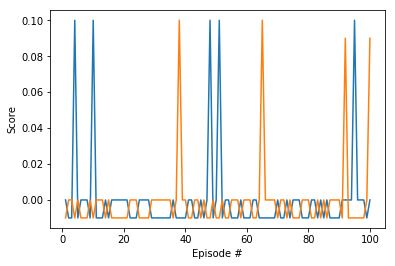

Episode 200	Average Score: 0.00625	Score: 0.00000 0.09000 Tcount:3044

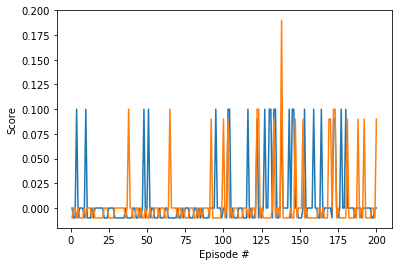

Episode 300	Average Score: 0.01200	Score: 0.00000 0.09000 Tcount:313

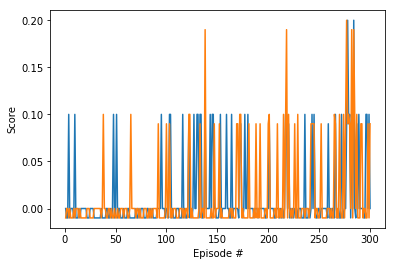

Episode 400	Average Score: 0.01775	Score: 0.00000 0.09000 Tcount:303

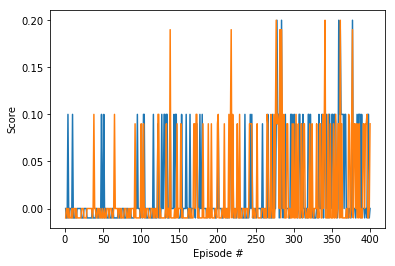

Episode 500	Average Score: 0.03080	Score: 0.10000 -0.01000 Tcount:32

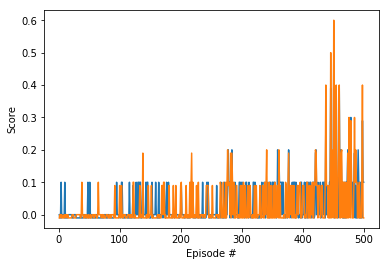

Episode 600	Average Score: 0.27449	Score: 2.59000 2.60000 Tcount:1001


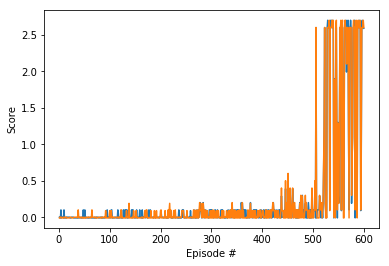

Episode 700	Average Score: 0.37581	Score: 2.60000 2.70000 Tcount:1001


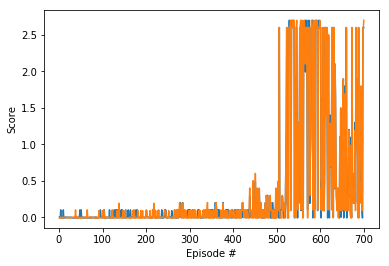

Episode 800	Average Score: 0.53514	Score: 1.59000 1.70000 Tcount:6281


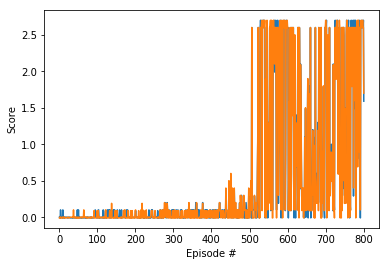

Episode 821	Average Score: 0.54598	Score: 0.79000 0.80000 Tcount:3451

KeyboardInterrupt: 

In [13]:
scores = maddpg.maddpg_trainingg()

(2,)
2


IndexError: too many indices for array

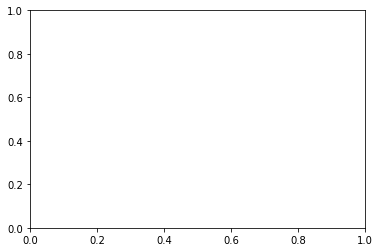

In [18]:
print(np.shape(scores))
print(len(scores))
scores_all = np.array(scores)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores[:,1])+1), scores[:,1])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores[:,0])+1), scores[:,0] , 'r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


NameError: name 'num_agents' is not defined

In [33]:
import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return pst_now.strftime(format)

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor0.pth'))
agent.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
agent.actor_local

In [ ]:
# env_info = env.reset(train_mode=False)[brain_name]

In [ ]:
print(env_info)

In [ ]:
a = [i if i==0 else 5 for i in range(2)]
a

In [ ]:
b = range(2)
for i in b:
    print(i)

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
states = np.reshape(states , (1,48))
print(states)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
Agents = maddpg.agents
for i in range(5):
    while True:
        #states = torch.from_numpy(states).float().to(device)

        actions = [maddpg.agents[i].act2(states[:,i*(maddpg.state_size):(i*maddpg.state_size)+maddpg.state_size] ,False , noise = 0) for i in range(2)]

        actions = np.concatenate((actions[0],actions[1]), axis=0)
        #print(actions)
        actions = np.reshape(actions, (1, 4))
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = np.reshape(next_states , (1,48))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.33374405 -1.5
  -0.          0.         -6.79315376  5.97645617 -0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4033308  -1.5
   0.          0.          6.79315376  5.97645617  0.          0.        ]]
Total score (averaged over agents) this episode: 2.600000038743019


When finished, you can close the environment.

In [20]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 